# Get all user submissions via API calls to Codeforces

This notebook contains functions for API calls to codeforces to obtain all user submissions
(contest and practice) as well as hacks from during contest.

In [1]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
import sys
import time

## Fn: get user submissions

In [45]:
def getUserSubmissions(handle):
    max_try_count = 5
    tries = 0

    maxcount = '100000000'
    url = 'http://codeforces.com/api/user.status?handle=' + handle + '&from=1&count=' + maxcount

    while tries < max_try_count:
        try:
            r = requests.get(url).json()['result']

            arr = []
            keys = ['testset', 'passedTestCount', 'author', 'relativeTimeSeconds', 
                    'language', 'memoryBytes', 'timeMilliseconds', 'problem_name', 'problem_index',
                    'problem_tags', 'points', 'contestID', 'verdict', 'id', 'participantType', 'startTimeSeconds']

            for rr in r:
                temp = dict.fromkeys(keys)
                temp['author'] = rr['author']['members'][0]['handle']
                temp['startTimeSeconds'] = rr['creationTimeSeconds']
                if 'startTimeSeconds' not in rr['author']:
                    temp['participantType'] = 'GYM'
                else:
                    temp['participantType'] = rr['author']['participantType']
                temp['id'] = rr['id']
                try:
                    temp['verdict'] = rr['verdict']
                except KeyError:
                    print temp
                    sys.exit()
                temp['contestID'] = rr['contestId']
                if 'points' not in rr['problem']:
                    temp['points'] = 0
                else:
                    temp['points'] = rr['problem']['points']
                temp['problem_tags'] = rr['problem']['tags']
                temp['problem_index'] = rr['problem']['index']
                temp['problem_name'] = rr['problem']['name']
                temp['timeMilliseconds'] = rr['timeConsumedMillis']
                temp['memoryBytes'] = rr['memoryConsumedBytes']
                temp['language'] = rr['programmingLanguage']
                temp['relativeTimeSeconds'] = rr['relativeTimeSeconds']
                temp['passedTestCount'] = rr['passedTestCount']
                temp['testset'] = rr['testset']

                arr.append(temp)
            return pd.DataFrame.from_dict(arr)
        except:
            print "error while processing", url
            print "waiting 10 seconds before trying again"
            time.sleep(10)
            tries += 1

            if tries > max_try_count:
                print "max tries exceeded, aborting"
                sys.exit()

## Fn: get user rating history

In [21]:
from time import sleep
def getUserRatingHistory(handle):
    maxtries = 5
    tries = 0
    while tries < maxtries:
        try:
            url = 'http://codeforces.com/api/user.rating?handle=' + handle
            print url
            r = requests.get(url).json()['result']
            return pd.DataFrame.from_dict(r)
        except:
            tries += 1
            sleep(5)
    print "ERROR GETTING USER INFO FOR", handle

## Fn: get contest hacks

In [ ]:
from time import sleep
def getContestHacks(contest):
    maxtries = 5
    tries = 0
    while tries < maxtries:
        try:
            url = 'http://codeforces.com/api/contest.hacks?contestId=' + contest

            r = requests.get(url).json()['result']
            return pd.DataFrame.from_dict(r)
        except:
            tries += 1
            sleep(5)
    print "ERROR GETTING USER INFO FOR CONTEST", contest

## Fn: get list of users

In [4]:
url = 'http://codeforces.com/api/user.ratedList'
users = requests.get(url).json()['result']

allHandles = []
for u in users:
    allHandles.append(u['handle'])

In [5]:
len(allHandles)

103417

export to file

In [ ]:
with open('all_handles.txt', 'w') as f:
    for u in allHandles:
        f.write(u + '\n')

# API Calls to get user info 

(0, 2000)

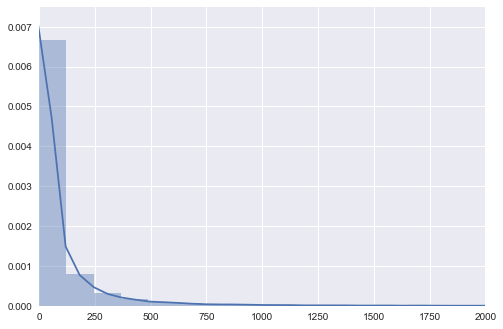

In [39]:
import seaborn as sns
sns.distplot(submission_cnts)
ax = plt.gca()
ax.set_xlim([0, 2000])

In [48]:
lastidx = [i for i,a in enumerate(allHandles) if a=='vbansal027']
print lastidx
print allHandles[lastidx[0]]

[80502]
vbansal027


In [ ]:
from os.path import exists
filename = 'all_submissions.csv'
# get user submission history
submission_dfs = []
submission_cnts = []

last_idx = lastidx[0]+1

for idx, user in enumerate(allHandles[last_idx:]):
    df = getUserSubmissions(user)
    submission_cnts.append(df.shape[0])
    if len(df) > 50:
        submission_dfs.append(df)

    if len(submission_dfs) >= 10:
        out_df = pd.concat(submission_dfs)
        print "writing", len(out_df), "lines to file..."
        out_df.to_csv(filename, index=False, mode='a', header=(not exists(filename)), encoding='utf-8')
        submission_dfs = []

# save anything left in out_df that's not a multiple of 10
out_df = pd.concat(submission_dfs)
out_df.to_csv(filename, index=False, mode='a', header=(not exists(filename)), encoding='utf-8')

In [ ]:
ratings_dfs = []

last_idx = 0
# get handles
with open('missing_handles.txt') as f:
    allHandles = [line.strip() for line in f.readlines()]
    
# api query
for idx, user in enumerate(allHandles[last_idx:]):
    df = getUserRatingHistory(user)
    
    # for now, keep all ratings
    ratings_dfs.append(df)
    print last_idx + idx, user
    print "ratings_dfs len:", len(ratings_dfs)
    if len(ratings_dfs) >= 10:
        out_df = pd.concat(ratings_dfs)
        print "--------------------- writing", len(out_df), "lines to file..."
        with open('rating_histories.csv', 'a') as f:
            out_df.to_csv(f, index=False, header=False, encoding='utf-8')
        ratings_dfs = []

# save anything left in out_df that's not a multiple of 10
out_df = pd.concat(ratings_dfs)
with open('rating_histories.csv', 'a') as f:
    out_df.to_csv(f, index=False, header=False, encoding='utf-8')